Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

In [1]:
import time
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

import os
from copy import deepcopy
from inspect import signature
from typing import List, Optional, Union
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.cat_boost import CatBoostEncoder
import catboost as cb
import lightgbm as lgb

In [2]:
def model_CV(model, X, y, cv, categorical=None):
    estimators, fold_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    
    print(f'{time.ctime()}, cross-validation, {X.shape[0]} rows, {X.shape[1]} cols')
    if categorical:
        categorical = list(set(categorical) & set(X.columns))
        X[categorical] = X[categorical].astype(str)
        
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=100
        )
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f'Fold {fold+1}, valid score = {round(score, 5)}')
        fold_scores.append(round(score, 5))
        estimators.append(model)
        
    print(f'Score by each fold: {fold_scores}')
    print('='*65)
    return estimators, oof_preds

def estimators_pred(estimators, X, categorical=None):
    oof_preds = np.zeros(X.shape[0])
    
    if categorical:
        categorical = list(set(categorical) & set(X.columns))
        X[categorical] = X[categorical].astype(str)
        
    for estimator in estimators:
        oof_preds = model.predict_proba(X)[:, 1]
        
    return oof_preds

In [3]:
data = pd.read_pickle('../../CourseWork/data.pkl')

In [4]:
data.head(3)

,application_number,target,name_contract_type_cash,name_contract_type_credit_card,name_contract_type_nan,childrens,total_salary,amount_credit,amount_annuity,region_population,...,credit_type_loan_for_business_development_mean,credit_type_loan_for_purchase_of_shares_margin_lending_mean,credit_type_loan_for_the_purchase_of_equipment_mean,credit_type_loan_for_working_capital_replenishment_mean,credit_type_microloan_mean,credit_type_mobile_operator_loan_mean,credit_type_mortgage_mean,credit_type_real_estate_loan_mean,credit_type_unknown_type_of_loan_mean,credit_type_nan_mean
0,123687442,0.0,1,0,0,1.0,157500.0,855000.0,25128.0,0.019101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,123597908,1.0,1,0,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,123526683,0.0,1,0,0,0.0,135000.0,1006920.0,42660.0,0.026392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0


In [5]:
mask = data['target'].isnull()
features_to_drop = ['application_number', 'target']

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train['target'], test['application_number']
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorical = train.dtypes[train.dtypes == 'object'].index.tolist()
numerical = list(set(train.columns) - set(categorical))

train = train.replace(np.inf, np.nan)
test = test.replace(np.inf, np.nan)

In [6]:
scores = pd.DataFrame()

In [7]:
test_scores = pd.DataFrame()

In [8]:
test_scores = pd.DataFrame()

In [9]:
models = dict()

#### 1.
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [10]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

LightGBM

In [11]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [12]:
model = lgb.LGBMClassifier(**params)
estimators, scores['LGBMClassifier'] = model_CV(model=model, 
                                              X=train.fillna(-9999), 
                                              y=target, 
                                              cv=cv, 
                                              categorical=categorical)

Mon Oct 25 22:47:41 2021, cross-validation, 110093 rows, 181 cols
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.722272	valid_1's auc: 0.712992
[200]	training's auc: 0.743574	valid_1's auc: 0.722494
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.743574	valid_1's auc: 0.722494
Fold 1, valid score = 0.72249
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.724537	valid_1's auc: 0.700021
[200]	training's auc: 0.746259	valid_1's auc: 0.709055
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.746259	valid_1's auc: 0.709055
Fold 2, valid score = 0.70906
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.72388	valid_1's auc: 0.703791
[200]	training's auc: 0.746898	valid_1's auc: 0.712185
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.746898	valid_1's auc: 0.712185
Fold 3, valid score = 0.71218
Training until validati

In [13]:
models['LGBMClassifier'] = {
    'model': model,
    'params': params,
    'estimators': estimators
}

XGBoost

In [14]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [15]:

model = xgb.XGBClassifier(**params)
estimators, scores['XGBClassifier'] = model_CV(model=model, 
                                              X=train.fillna(-9999), 
                                              y=target, 
                                              cv=cv, 
                                              categorical=categorical)

Mon Oct 25 22:48:17 2021, cross-validation, 110093 rows, 181 cols
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[100]	validation_0-auc:0.72293	validation_1-auc:0.72465
[126]	validation_0-auc:0.72293	validation_1-auc:0.72465
Fold 1, valid score = 0.72476
[0]	validation_0-auc:0.59817	validation_1-auc:0.58757
[100]	validation_0-auc:0.72607	validation_1-auc:0.71251
[159]	validation_0-auc:0.72698	validation_1-auc:0.71365
Fold 2, valid score = 0.71365
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[100]	validation_0-auc:0.72548	validation_1-auc:0.71949
[146]	validation_0-auc:0.72548	validation_1-auc:0.71949
Fold 3, valid score = 0.71949
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[100]	validation_0-auc:0.72669	validation_1-auc:0.71386
[128]	validation_0-auc:0.72669	validation_1-auc:0.71386
Fold 4, valid score = 0.71386
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[100]	validation_0-auc:0.72858	validation_1-auc:0.70308
[128]	validation_0-auc:0.72858	validatio

In [16]:
models['XGBClassifier'] = {
    'model': model,
    'params': params,
    'estimators': estimators
}

In [17]:
corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

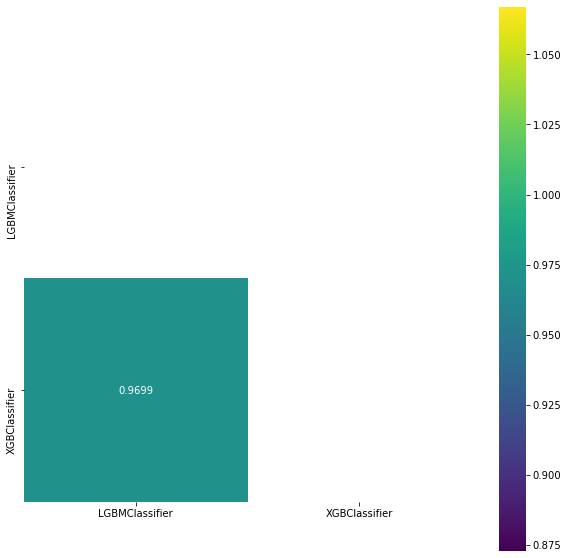

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Кореляция для двух моделей довольно высокая

In [19]:
test_scores['LGBMClassifier'] = estimators_pred(
                                    estimators=models['LGBMClassifier']['estimators'], 
                                    X=test,
                                    categorical=categorical)

In [20]:
test_scores['XGBClassifier'] = estimators_pred(
                                    estimators=models['XGBClassifier']['estimators'], 
                                    X=test,
                                    categorical=categorical)

In [21]:
corr = test_scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

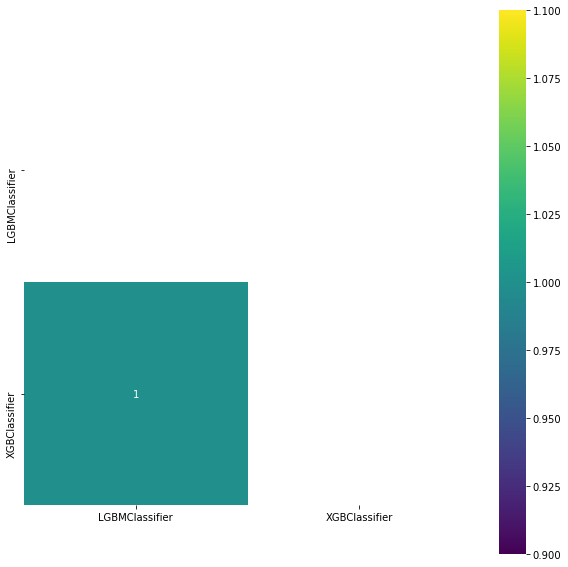

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Но для тестовых данных кореляция еще выше

#### 2.
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [23]:
score_lgbm = roc_auc_score(target, scores['LGBMClassifier'])
score_lgbm

0.7090317705158078

In [24]:
score_xgb = roc_auc_score(target, scores['XGBClassifier'])
score_xgb

0.7143761317131095

In [25]:
(score_lgbm + score_xgb) / 2

0.7117039511144587

In [26]:
mean_score_2 = scores.sum(axis=1)
roc_auc_score(target, mean_score_2)

0.7130917497495382

Усреднение работает неплохо. Значение качества много лучше просто усредненного

#### 3.
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

CatBoost

In [27]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [28]:
model = cb.CatBoostClassifier(**cb_params)
estimators, scores['CatBoostClassifier'] = model_CV(model=model, 
                                              X=train.fillna(-9999), 
                                              y=target, 
                                              cv=cv, 
                                              categorical=categorical)

Mon Oct 25 22:50:53 2021, cross-validation, 110093 rows, 181 cols
0:	test: 0.5535711	test1: 0.5509049	best: 0.5509049 (0)	total: 227ms	remaining: 45.1s
100:	test: 0.7117872	test1: 0.7175109	best: 0.7175109 (100)	total: 6.45s	remaining: 6.32s
199:	test: 0.7246892	test1: 0.7249679	best: 0.7250084 (196)	total: 12.7s	remaining: 0us

bestTest = 0.7250083644
bestIteration = 196

Shrink model to first 197 iterations.
Fold 1, valid score = 0.72501
0:	test: 0.5506185	test1: 0.5525461	best: 0.5525461 (0)	total: 52.2ms	remaining: 10.4s
100:	test: 0.7153906	test1: 0.7041262	best: 0.7041262 (100)	total: 6.73s	remaining: 6.6s
199:	test: 0.7278671	test1: 0.7123676	best: 0.7124215 (197)	total: 13.2s	remaining: 0us

bestTest = 0.7124215033
bestIteration = 197

Shrink model to first 198 iterations.
Fold 2, valid score = 0.71242
0:	test: 0.5072603	test1: 0.5102073	best: 0.5102073 (0)	total: 51.3ms	remaining: 10.2s
100:	test: 0.7129998	test1: 0.7084109	best: 0.7085021 (99)	total: 6.26s	remaining: 6.13s
19

In [29]:
models['CatBoostClassifier'] = {
    'model': model,
    'params': params,
    'estimators': estimators
}

In [30]:
corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

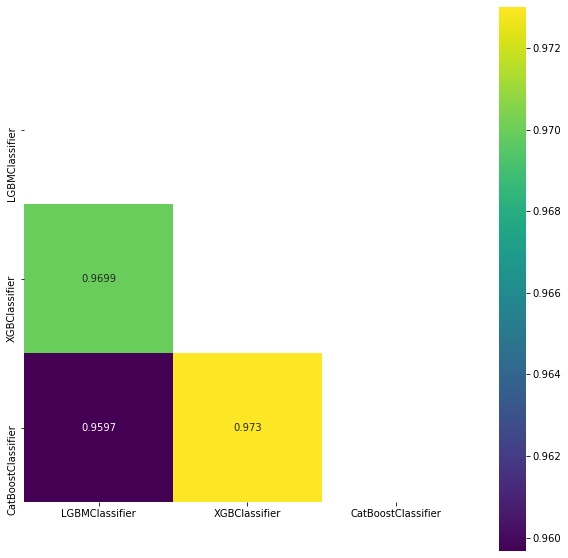

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Видим, что катбуст заметно слабее коррелирует с остальными моделями

In [32]:
test_scores['CatBoostClassifier'] = estimators_pred(
                                    estimators=models['CatBoostClassifier']['estimators'], 
                                    X=test,
                                    categorical=categorical)

In [33]:
corr = test_scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

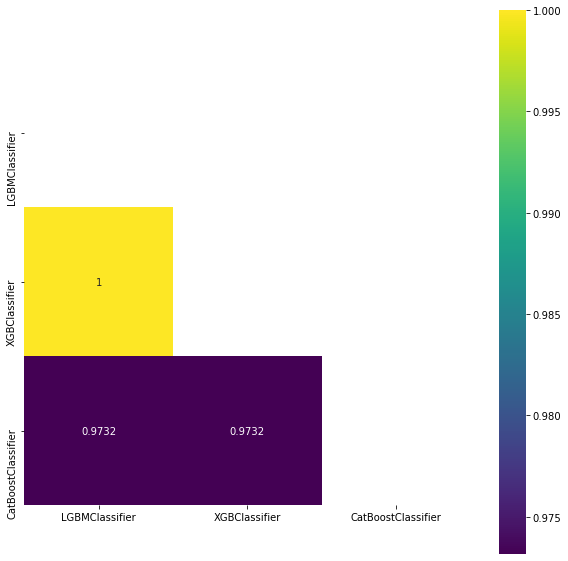

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Единица никуда не делась, но и не появилась для катбуста

#### 4. 
Выполнить задание 2 для трех моделей.

In [35]:
score_lgbm

0.7090317705158078

In [36]:
score_xgb

0.7143761317131095

In [37]:
score_cat = roc_auc_score(target, scores['CatBoostClassifier'])
score_cat

0.7132997193289512

In [38]:
(score_lgbm + score_xgb + score_cat) / 3

0.7122358738526229

In [39]:
mean_score_3 = scores.sum(axis=1)
roc_auc_score(target, mean_score_2)

0.7130917497495382

Значение качества всё еще лучше просто усредненного, но странно, что оно не улучшилось от появления новой модели, которая более слабо коррелирует с остальными

Что-то очень сомневаюсь в правильности выполнения этого ДЗ, но стараюсь больше времени уделять курсовой

#### 5. (опция) 
Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

#### 6. (опция) 
Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.